In [32]:

!pip install catboost

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor
import holidays as hd
import datetime

In [34]:

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [75]:

holidays_events = pd.read_csv('holidays_events.csv')
items = pd.read_csv('items.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
train = pd.read_csv('train.csv', nrows=7000000)

In [36]:
display(train.head())
train.shape

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


(7000000, 6)

In [37]:

# Групируем данные.
group_train = train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
group_train = group_train.to_frame(name='sales')
# Переводим индех в datetime.
group_train.index = pd.to_datetime(group_train.index)

In [38]:

group_train.head()

,sales
date,
2013-01-01,2511.619
2013-01-02,496092.418
2013-01-03,361429.231
2013-01-04,354459.677
2013-01-05,477350.121


In [39]:

print('Количество элементов в таблице -', group_train.shape[0])

Количество элементов в таблице - 166


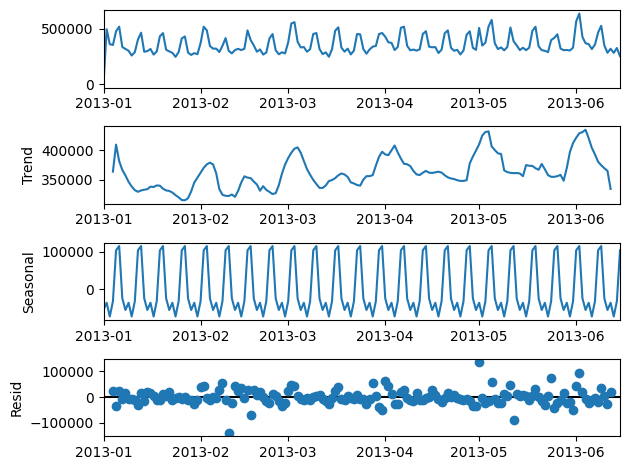

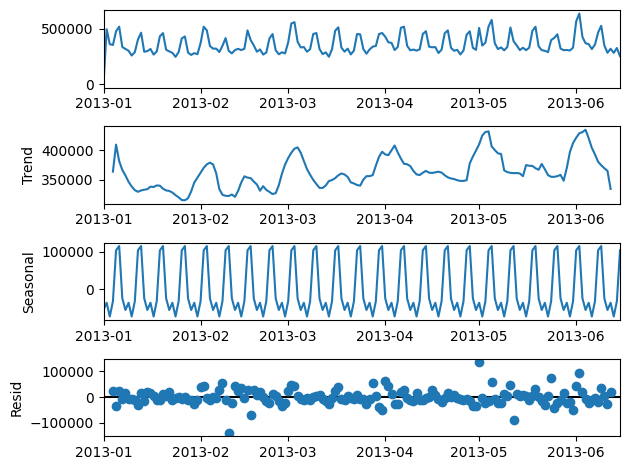

In [40]:
## Сезонная декомпозиция

decomposition = seasonal_decompose(group_train, model='additive')
decomposition.plot()

In [41]:

trend_part = decomposition.trend # трендовая составляющаяя
seasonal_part = decomposition.seasonal # сезонная составляющаяя
residual_part = decomposition.resid # шум

Text(0.5, 1.0, 'Трендовая составляющая')

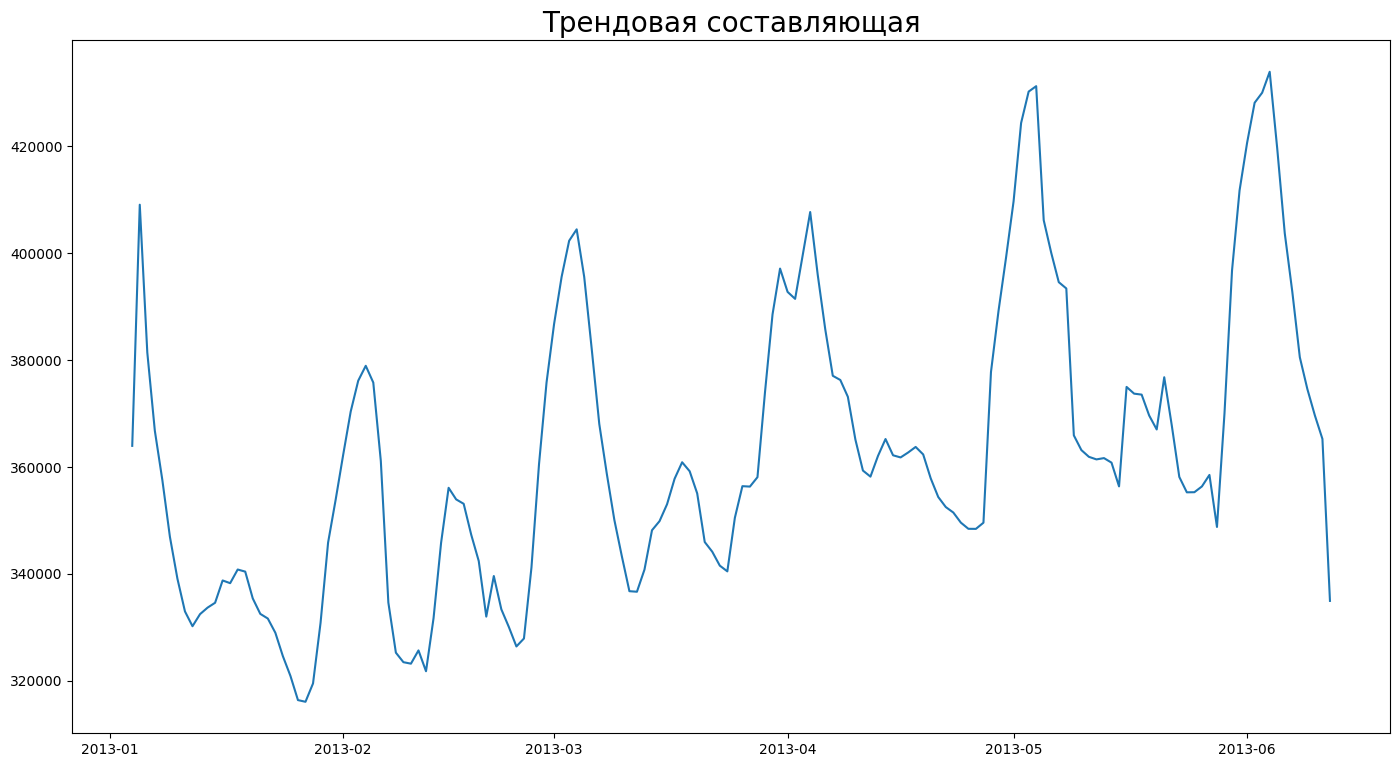

In [42]:

# Посмотрим по ближе на трендовую составляющую.
fig = plt.figure(figsize=(17, 9))
plt.plot(trend_part)
plt.title('Трендовая составляющая', size=20)

Text(0.5, 1.0, 'Шум')

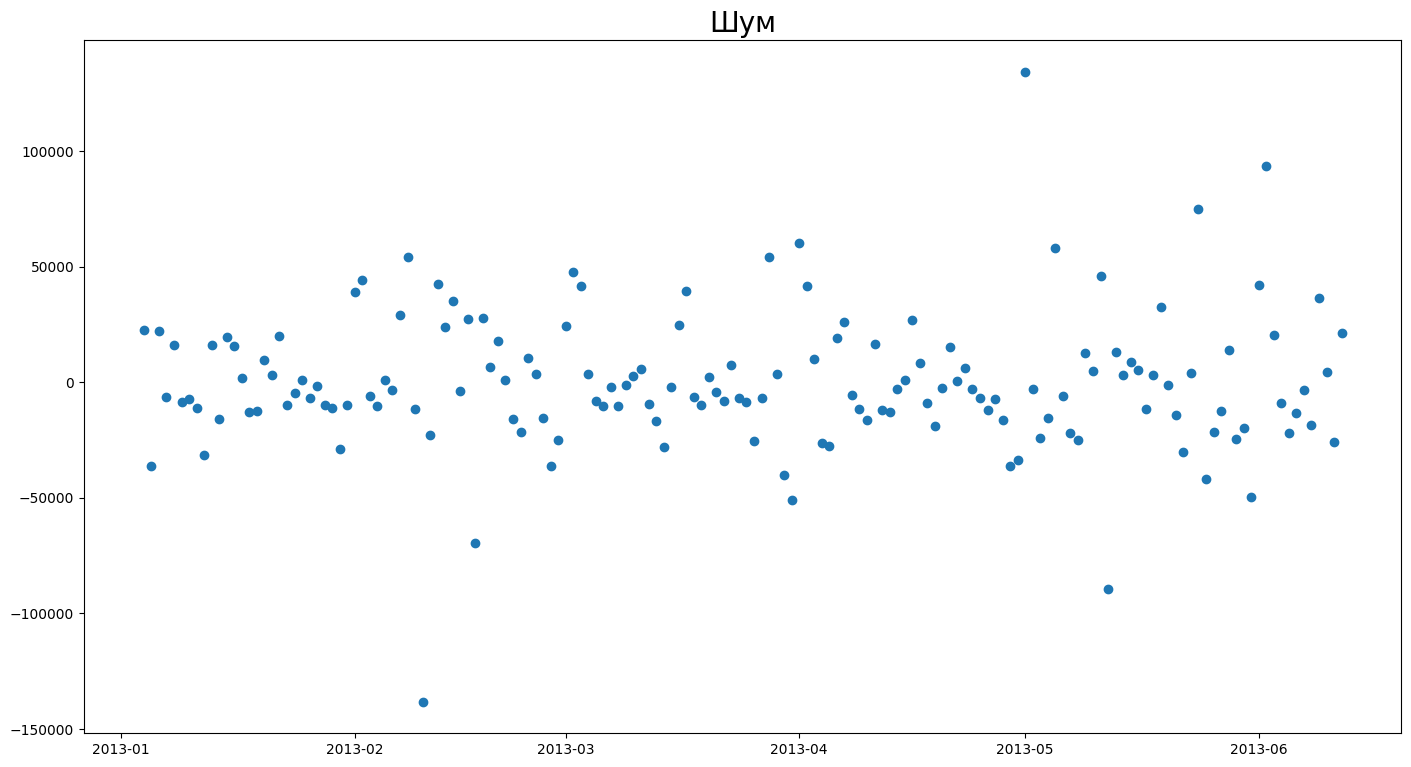

In [43]:

# Посмотрим по ближе на шум.
fig = plt.figure(figsize=(17, 9))
plt.scatter(x=residual_part.index, y=residual_part.values)
plt.title('Шум', size=20)

In [44]:
 # тест Дики-Фуллера :

from statsmodels.tsa.stattools import adfuller

test = adfuller(group_train["sales"])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -2.5356193413466586
p-value:  0.10704649763465846
Critical values:  {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}
ряд не стационарен


#  валидации временных рядов

In [45]:

tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(group_train['sales'])
for train_index, test_index in train_test_groups:
    print('Размер тренировочного набора :', len(train_index), 'Размер тестового набора :', len(test_index))

Размер тренировочного набора : 145 Размер тестового набора : 7
Размер тренировочного набора : 152 Размер тестового набора : 7
Размер тренировочного набора : 159 Размер тестового набора : 7


# Формирование признаков для временного ряда

In [46]:

# Построим скользящее среднее.
group_train['mean_sales'] = group_train['sales'].rolling(window=5).mean()
# Построим скользящее квадратичное отклонение.
group_train['std_sales'] = group_train['sales'].rolling(window=5).std()
# Построим полосы Боллинджера.
group_train['upper'] = group_train['mean_sales'] + 3 * group_train['std_sales']
group_train['lower'] = group_train['mean_sales'] - 3 * group_train['std_sales']

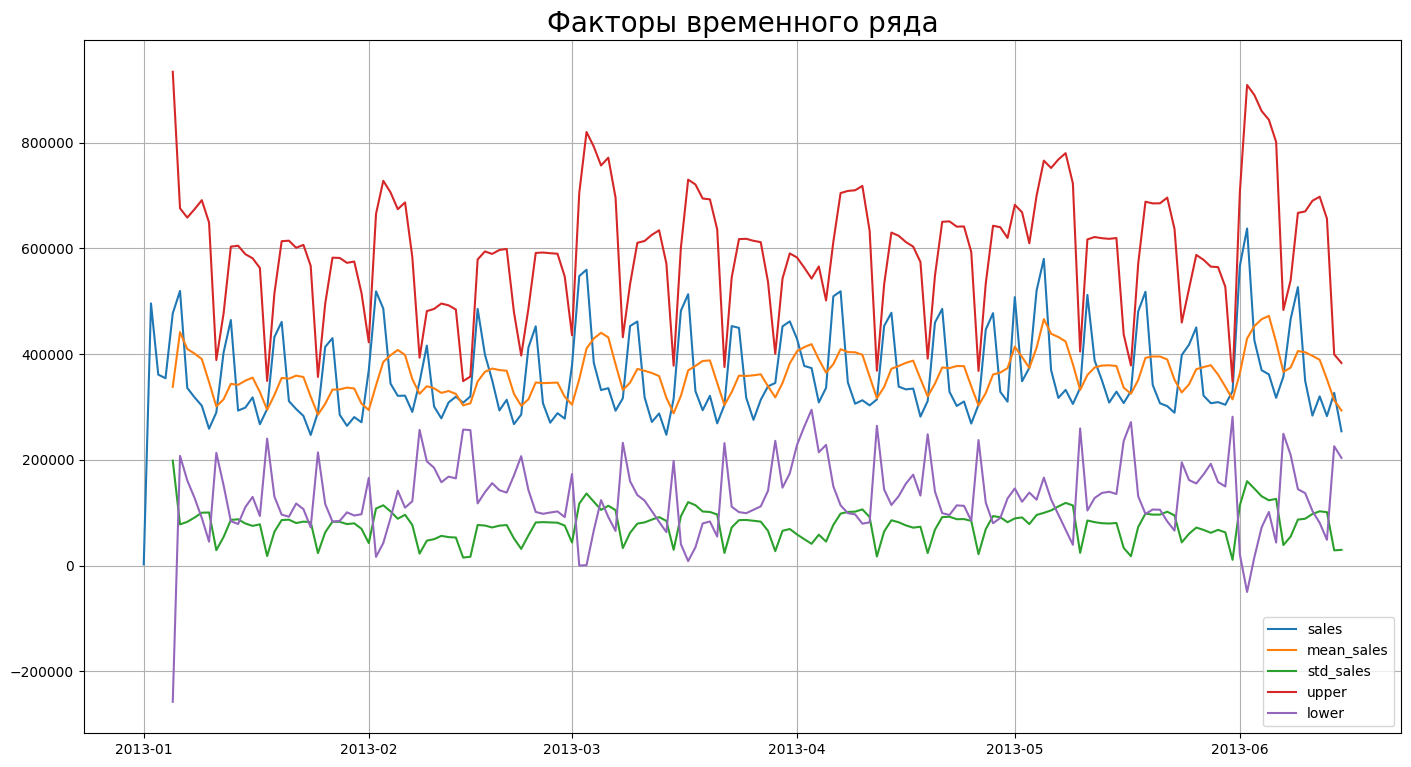

In [48]:

fig = plt.figure(figsize=(17, 9))
plt.plot(group_train)
plt.legend(['sales', 'mean_sales', 'std_sales', 'upper', 'lower'])
plt.title('Факторы временного ряда', size=20)
plt.grid()

In [49]:

def unit_sales(value):
  '''Функция считает среднее арифметическое между максимальным и минимальным значением.'''
  return (value.max() - value.min()) / len(value)

In [50]:
group_train['unit_sales']  = group_train['sales'].rolling(window=10).apply(unit_sales, raw=False)

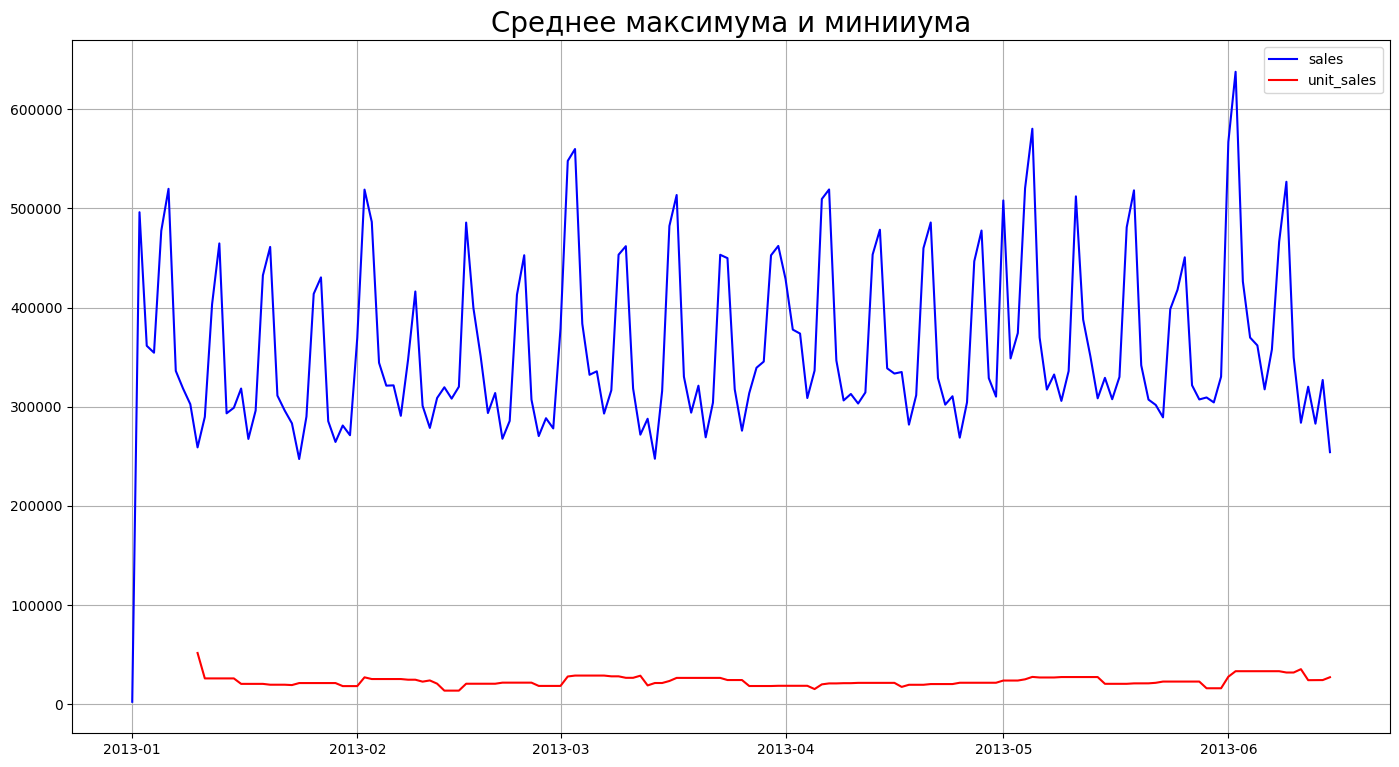

In [51]:

fig = plt.figure(figsize=(17, 9))
plt.plot(group_train['sales'], c='b')
plt.plot(group_train['unit_sales'], c='r')
plt.legend(['sales', 'unit_sales'])
plt.title('Среднее максимума и минииума', size=20)
plt.grid()

In [52]:
# Построим среднее и экспоненциальное среднее.
group_train['mean_50'] = group_train['sales'].rolling(window=50).mean()
group_train['ewm_10'] = group_train['sales'].ewm(min_periods=10, span=10).mean()
group_train['subtraction'] = group_train['mean_50'] - group_train['ewm_10']

In [53]:

group_train['sign'] = np.sign(group_train['subtraction'])
group_train['diff_sign'] = group_train['sign'].diff().dropna()
group_train_dropna = group_train.dropna()

# Найдем индексы точек пересечения скользящих средних.
intersection_points = group_train_dropna[group_train_dropna['diff_sign'] != 0].index
print(intersection_points)

DatetimeIndex(['2013-02-20', '2013-02-24', '2013-02-26', '2013-03-02',
               '2013-03-13', '2013-03-16', '2013-03-20', '2013-03-24',
               '2013-03-26', '2013-03-30', '2013-04-11', '2013-04-13',
               '2013-04-17', '2013-04-21', '2013-04-24', '2013-04-28',
               '2013-04-30', '2013-05-01', '2013-05-10', '2013-05-11',
               '2013-05-14', '2013-05-19', '2013-05-21', '2013-05-26',
               '2013-05-28', '2013-06-01', '2013-06-12'],
              dtype='datetime64[ns]', name='date', freq=None)


In [54]:


# Получите лаговые факторы с 7-го по 10-й предыдущих дней.
for i in range(7, 11):
  group_train[f'lag_{i}'] = group_train['sales'].shift(i)

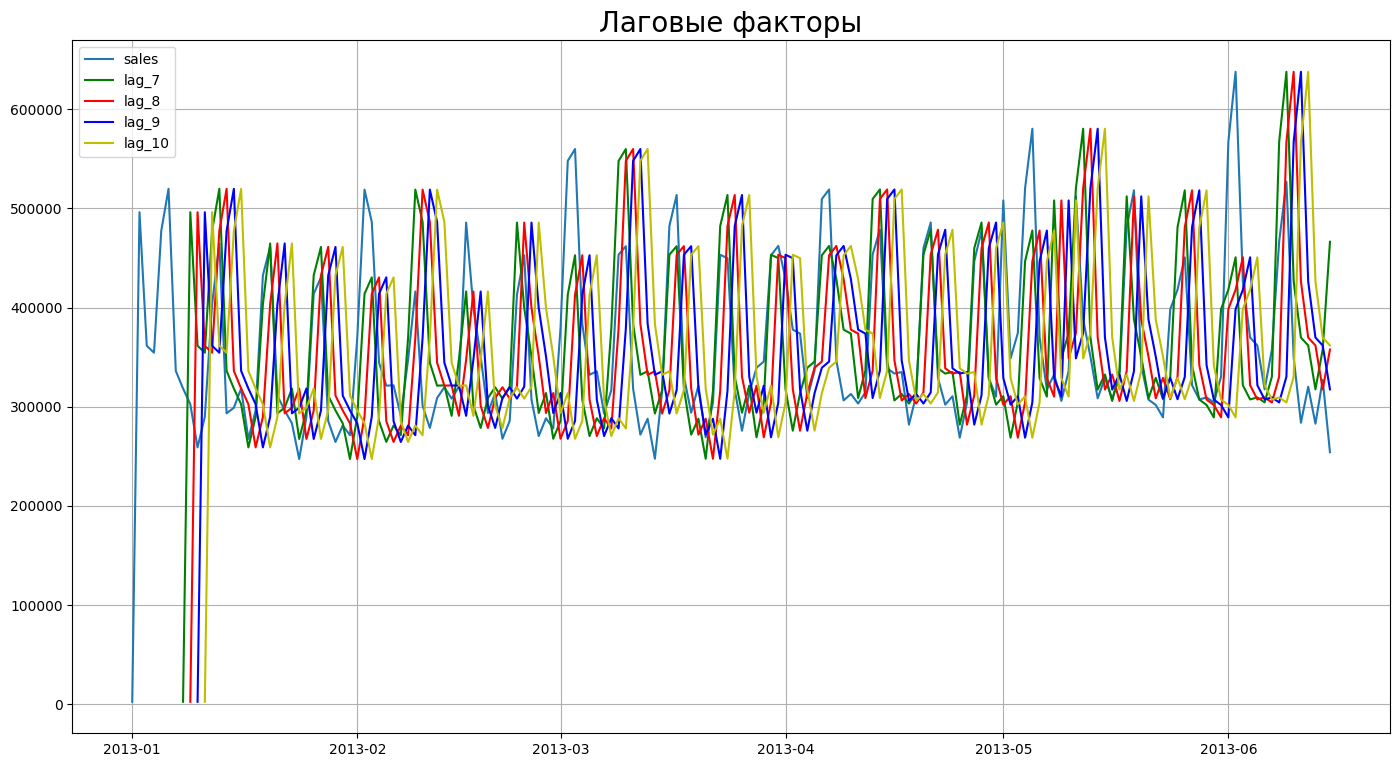

In [55]:

fig = plt.figure(figsize=(17, 9))
plt.plot(group_train['sales'])
plt.plot(group_train['lag_7'],  c='g')
plt.plot(group_train['lag_8'],  c='r')
plt.plot(group_train['lag_9'],  c='b')
plt.plot(group_train['lag_10'],  c='y')
plt.legend(['sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
plt.title('Лаговые факторы', size=20)
plt.grid();

In [57]:

# Оставим продукт определенного номера.
arima_train = train[train['item_nbr'] == 103501]

In [58]:
# Групируем данные.
arima_train = arima_train.groupby('date')['unit_sales'].sum()
# Переводим серию в dataframe.
arima_train = arima_train.to_frame(name='sales')
# Переводим индех в datetime.
arima_train.index = pd.to_datetime(arima_train.index)

In [59]:

display(arima_train.head())
print(arima_train.shape)

,sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


(165, 1)


In [60]:
test = adfuller(arima_train['sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0] > test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда
    print ('Ряд не стационарен.')
else:
    print ('Ряд стационарен.')

adf:  -3.4442974672424866
p-value:  0.009538336828125842
Critical values:  {'1%': -3.474714913481481, '5%': -2.881008708148148, '10%': -2.5771508444444446}
Ряд стационарен.


In [61]:
# Модель скользящего среднего

def moving_average_forecast(data, window_size):

    forecast = []

    for time in range(len(data) - window_size):
        forecast.append(data[time:time + window_size].mean())

    return np.array(forecast)

moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(arima_train, moving_average_days )
moving_avg = [a for b in moving_avg for a in b]
moving_avg = pd.Series(moving_avg, index = arima_train[moving_average_days:].index)

In [62]:
print(moving_avg[-moving_average_days:].shape, arima_train[-moving_average_days:].shape)
print('MSE', mean_squared_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print('MAE', mean_absolute_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print('MAPE', mean_absolute_percentage_error(arima_train.values[-moving_average_days:], moving_avg[-moving_average_days:]))

(6,) (6, 1)
MSE 606.5370370370371
MAE 21.166666666666668
MAPE 0.26618249362800966


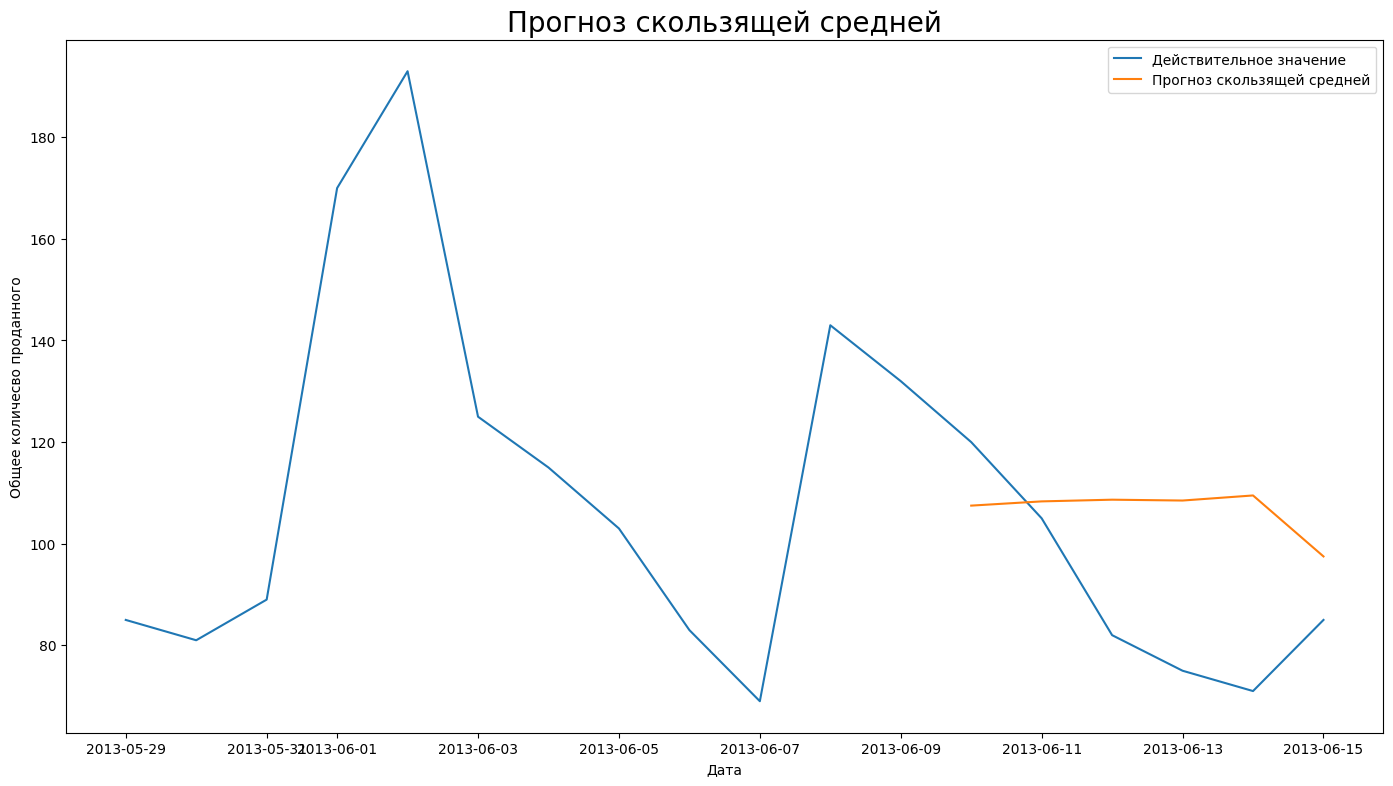

In [63]:
plt.figure(figsize=(17, 9))
plt.plot(arima_train[- shown_train_size:], label='Действительное значение')
plt.plot(moving_avg[-moving_average_days:], label='Прогноз скользящей средней')
plt.ylabel('Общее количесво проданного')
plt.xlabel('Дата')
plt.title('Прогноз скользящей средней', size=20)
plt.legend(loc='upper right')

In [64]:

# Будем предсказывать 2 дня.
predict_size = 2
# Получите лаговые факторы с 1-го по 6-й предыдущих дней.
for i in range(1, 7):
  arima_train[f'lag_{i}'] = arima_train['sales'].shift(i)

arima_train.dropna(inplace=True)

In [65]:

# Разделим данные на тренировочную и тестовую выборки.
X_train, y_train = arima_train[:-predict_size].drop(['sales'], axis=1), arima_train[:-predict_size]['sales']
X_test, y_test  = arima_train[-predict_size:].drop(['sales'], axis=1), arima_train[-predict_size:]['sales']

In [66]:

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
     

LinearRegression()

In [67]:

# Выведем коэффициенты и независимый член.
print(linreg_model.coef_)
print(linreg_model.intercept_)

[ 0.59862113 -0.28463708 -0.00185822 -0.0087091  -0.25168016  0.26428798]
75.45508949647481


In [68]:
# Сделаем предсказание.
pred = pd.Series(linreg_model.predict(X_test), index=X_test.index)
pred

date
2013-06-14    100.342630
2013-06-15    100.226974
dtype: float64

In [69]:

print('MSE', mean_squared_error(y_test, pred))
print('MAE', mean_absolute_error(y_test, pred))
print('MAPE', mean_absolute_percentage_error(y_test, pred))

MSE 546.4253288169831
MAE 22.28480192591931
MAPE 0.29620867343324436


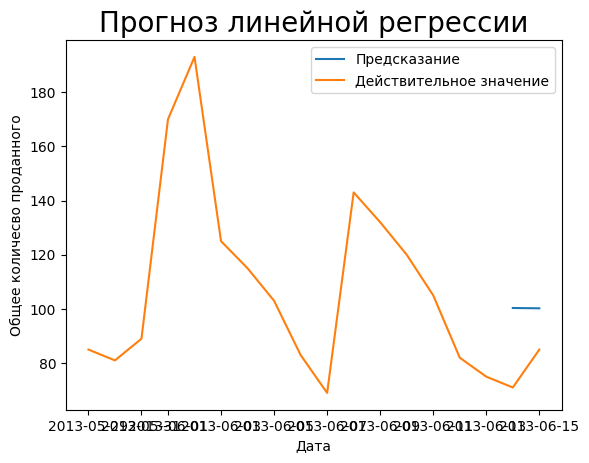

In [70]:
plt.plot(pred , label='Предсказание')
plt.plot(pd.concat([y_train, y_test], axis=0)[-shown_train_size:], label='Действительное значение')
plt.xlabel('Дата')
plt.ylabel('Общее количесво проданного')
plt.title('Прогноз линейной регрессии', size=20)
plt.legend(loc='upper right')
     

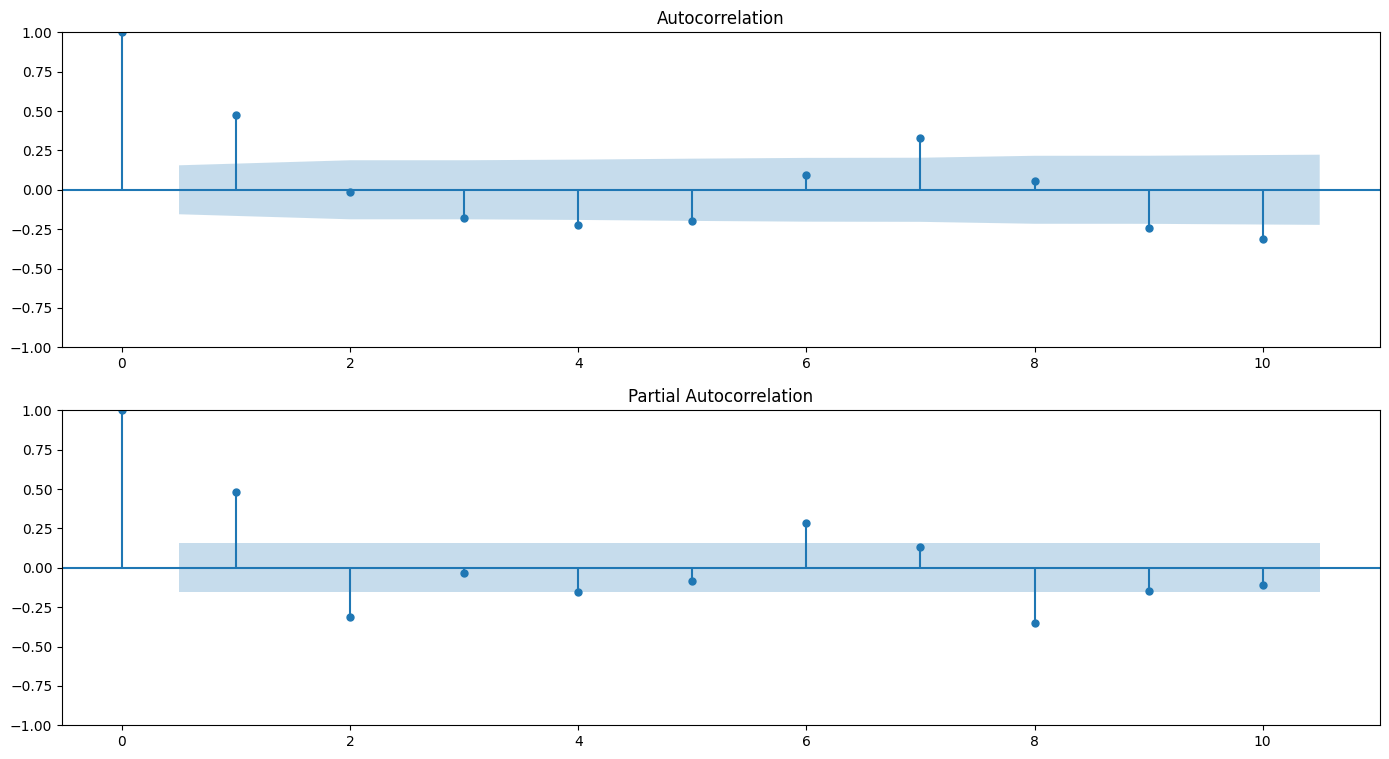

In [71]:
# Парметры для модели ARIMA

fig = plt.figure(figsize=(17, 9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_train['sales'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_train['sales'], lags=10, ax=ax2)

In [72]:
# Модель ARIMA

arima_model = ARIMA(y_train.values.reshape(-1), order=(2,0,1))
train_size = len(y_train)
test_size = predict_size
arima_predictions = arima_model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)

In [73]:
print('MSE', mean_squared_error(y_test, arima_predictions))
print('MAE', mean_absolute_error(y_test, arima_predictions))
print('MAPE', mean_absolute_percentage_error(y_test, arima_predictions))

MSE 766.2181289620926
MAE 27.640550492341923
MAPE 0.35551576527892326


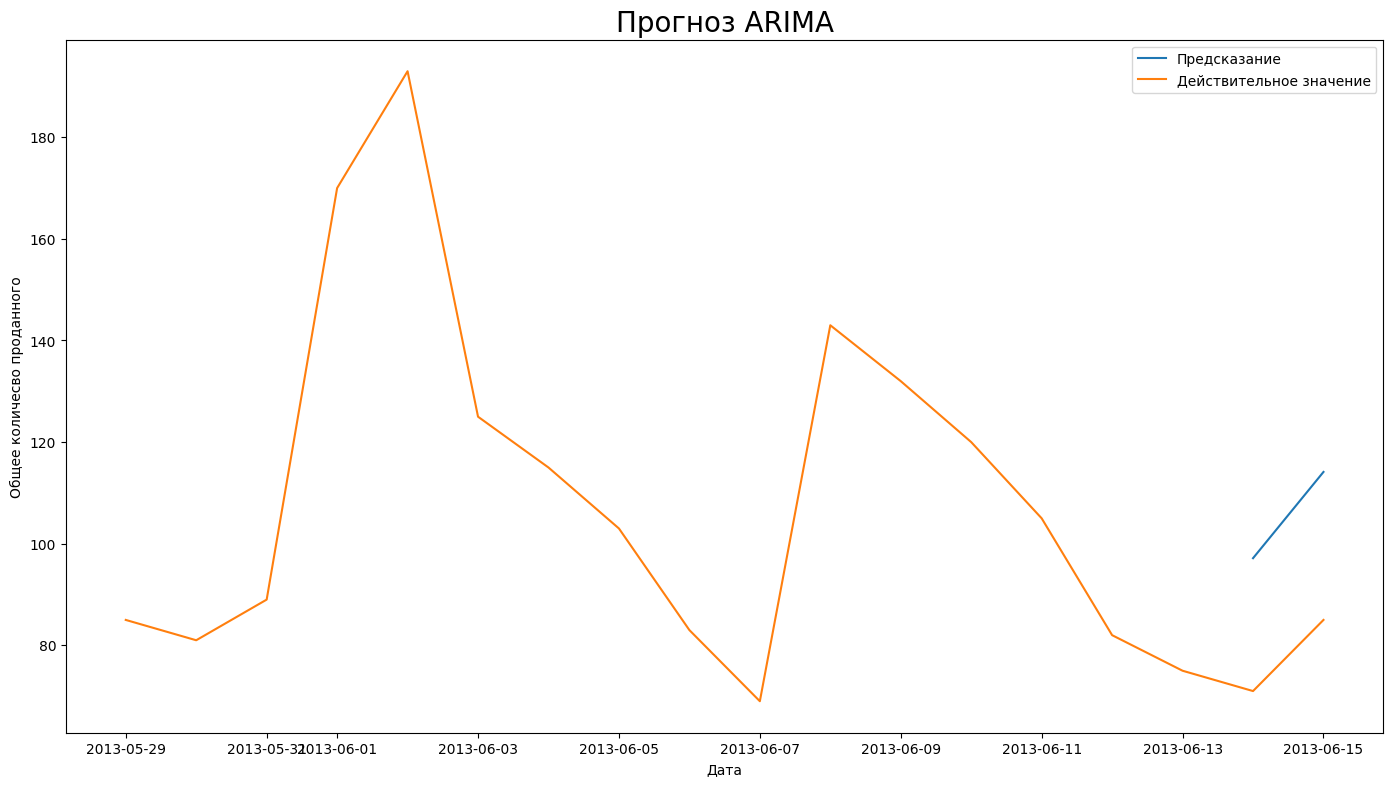

In [74]:

fig = plt.figure(figsize=(17, 9))
plt.plot(pd.Series(arima_predictions, index=y_test.index), label='Предсказание')
plt.plot(pd.concat([y_train, y_test], axis=0)[-shown_train_size:] ,label='Действительное значение')
plt.xlabel('Дата')
plt.ylabel('Общее количесво проданного')
plt.title('Прогноз ARIMA', size=20)
plt.legend(loc='upper right')

Вывод:

Для моделей линейной регрессии и скользящего среднего метрики практически одинаковы. Предсказательная способность отсутствует.

У модели ARIMA метрики хуже, но она правильно определила направление графика.